 # Base figure for Equation 1 of ASC project


In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, sigma2
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client(threads_per_worker = 1)

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23289909057344 and this is thread id 23288637802240.
Exception closing connection <sqlite3.Connection object at 0x152e4e183440>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/sit

In [3]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [4]:
session = cc.database.create_session()
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091', 'area_t', session, n=1) # needed for the plots I'll provide.

In [5]:
gdata_db='/home/156/wf4500/databases/access/DSW.db'
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

temp_session = cc.database.create_session(temporary_db)
session = cc.database.create_session()

start_time='1908-01'
end_time='1910-12'
time_slice=slice(start_time,end_time)
lat_slice=slice(-90,-55)

start_timeMOM6='1997-01'
end_timeMOM6='1999-12'
time_sliceMOM6=slice(start_timeMOM6,end_timeMOM6)

In [6]:
ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=lat_slice)
ht_50S = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=slice(-90,-50)).load()
land_mask = (ht*0).fillna(1)

In [7]:
areat_shelf, shelf_mask = shelf_mask_isobath(area_t)

In [8]:
shelf_mask_off = shelf_mask.where(shelf_mask<1)+1

In [9]:
ht.load()
print('loaded ocean depth')

loaded ocean depth


In [10]:
ht_offshelf = ht*shelf_mask_off

In [11]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '_corr.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()


ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '_corr.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()


In [12]:
bins_west = r_sq_annual_10deg.lon_bins-5 #western wedge of the 10 degree bins
bins_east = r_sq_annual_10deg.lon_bins+5 #western wedge of the 10 degree bins

## Plotting base figure

  ax325.contourf(land_mask.xt_ocean.values,

  plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,



(-80.0, -60.0)

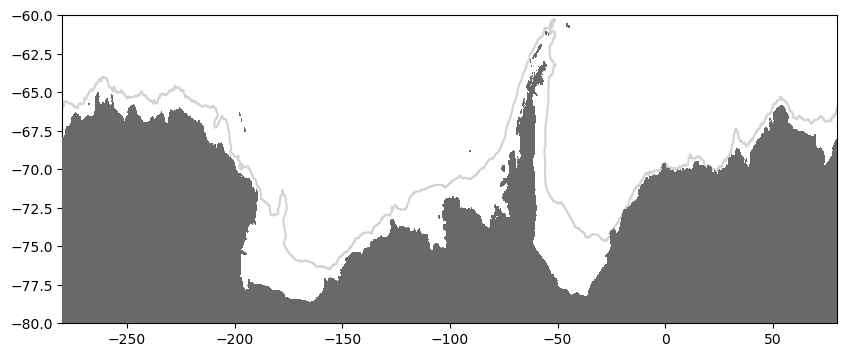

In [13]:
figure = plt.figure(figsize = (10, 4))
ax325 = plt.subplot(1,1,1)

ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             rasterized=True, zorder=6)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7)

ax325.set_ylim(-80,-60)
#ax325.set_xlim(-200,-100)


In [14]:
from matplotlib.colors import LightSource

test plot 1, around Glomar

In [15]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Text(0.5, 1.0, 'Heat Transport calculation')

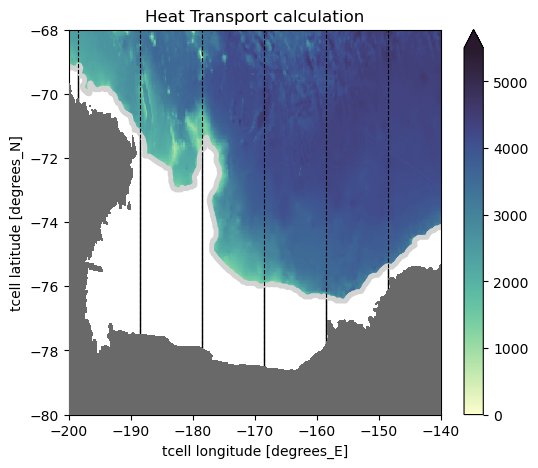

In [16]:
figure = plt.figure(figsize = (6, 5))
ax325 = plt.subplot(1,1,1)


ht_offshelf.plot(cmap=cmo.deep,vmin=0,vmax=5500,zorder=1)
ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             zorder=6)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidths=3.5,zorder=2)

for k in range(35):
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=1,color='k',zorder=0)
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=0.8,color='k',linestyle='--',zorder=5)

ax325.set_ylim(-80,-68)
ax325.set_xlim(-200,-140)
ax325.set_title('Heat Transport calculation')



test plot 2, East Antarctica with a more zonal coast

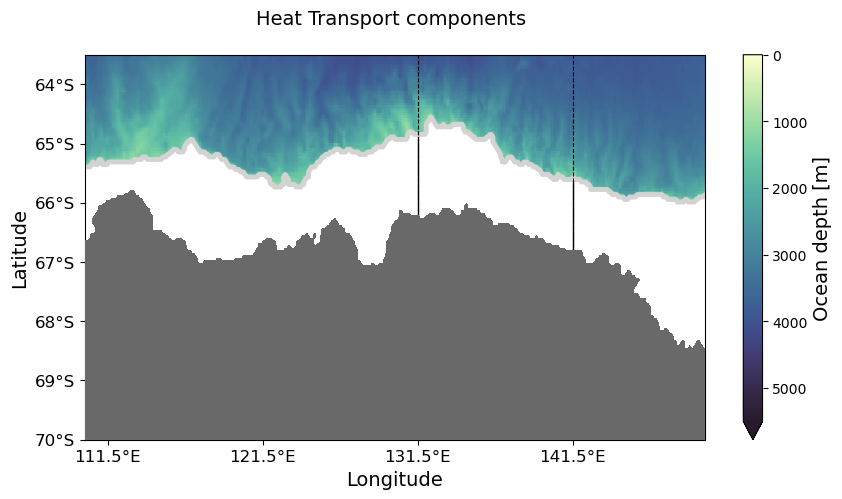

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/ioloop.py:750: RuntimeWarning: coroutine 'PeriodicCallback._run' was never awaited
  ret = callback()
2025-08-27 10:02:43,631 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils_comm.py"

In [25]:
figure = plt.figure(figsize = (10, 5))
ax325 = plt.subplot(1,1,1)


depth_contourf = ht_offshelf.plot(cmap=cmo.deep,vmin=0,vmax=5500,zorder=1)

depth_contourf.colorbar.set_label("Ocean depth [m]",fontsize = 14)
depth_contourf.colorbar.ax.invert_yaxis()
ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             zorder=6)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidths=3.5,zorder=2)

for k in range(5,10):
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=1,color='k',zorder=0)
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=0.8,color='k',linestyle='--',zorder=5)

# ax325.set_ylim(-70,-62)
# ax325.set_xlim(-280,-210)
ax325.yaxis.set_major_formatter(LatitudeFormatter())
ax325.xaxis.set_major_formatter(LongitudeFormatter())
ax325.set_xticks(ticks=bins_west)
ax325.tick_params(axis='x', labelsize=12)
ax325.tick_params(axis='y', labelsize=12)
ax325.set_ylim(-70,-63.5)
ax325.set_xlim(-250,-210)
ax325.set_xlabel('Longitude',fontsize = 14)
ax325.set_ylabel('Latitude',fontsize = 14)
ax325.set_title('Heat Transport components \n ',fontsize = 14)

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/base_schematic.png',dpi=300,bbox_inches='tight')

## ASC crossing is

I have a hint that our correlations are big mostly where the ASC crosses the isobath. SO Imma try to plot the Isobath vs the vertical mean ASC speed


In [121]:
u = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'u', session,chunks={}).\
sel(yu_ocean=lat_slice,st_ocean=slice(0,1250)).mean('time')

v = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'v', session,chunks={}).\
sel(yu_ocean=lat_slice,st_ocean=slice(0,1250)).mean('time')



In [127]:
#computing velocity
Vel = (((u**2)+(v**2))**0.5).compute()

This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(



In [150]:
st_edges = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_edges_ocean', session,n=1).diff('st_edges_ocean')
st_ocean = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_ocean', session,n=1)

In [151]:
dzt_mean = xr.DataArray(data = st_edges.values,coords={'st_ocean': st_ocean.values})

In [153]:
Vel_mean = Vel.weighted(dzt_mean).mean('st_ocean')

(-250.0, -210.0)

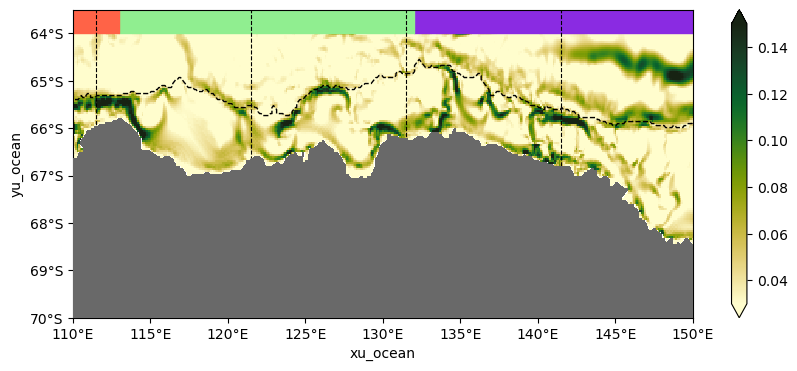

In [209]:
#Mertz region Checking
figure = plt.figure(figsize = (10, 4))
ax325 = plt.subplot(1,1,1)

#Vel.isel(st_ocean=0).plot.pcolormesh(cmap = cmo.speed,vmin=0,vmax=0.4,add_colorbar=True)
Vel_mean.plot.pcolormesh(cmap = cmo.speed,vmin=0.03,vmax=0.15,add_colorbar=True)
ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             zorder=6)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'black', linewidths=1,linestyles='--')


for k in range(35):
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=1,color='k',zorder=0)
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=0.8,color='k',linestyle='--',zorder=5)


ax325.fill_between([-29,-54],[-64,-64],[1,1], color = 'blueviolet')
ax325.fill_between([-178,-228],[-64,-64],[1,1], color = 'blueviolet')
ax325.fill_between([70,45],[-64,-64],[1,1], color = 'blueviolet')
## F regions
ax325.fill_between([-54,-56],[-64,-64],[1,1], color = 'lightgreen')
ax325.fill_between([-120,-178],[-64,-64],[1,1], color = 'lightgreen')
ax325.fill_between([-228,-247],[-64,-64],[1,1], color = 'lightgreen')
ax325.fill_between([-279,-258],[-64,-64],[1,1], color = 'lightgreen')
ax325.fill_between([70,80],[-64,-64],[1,1], color = 'lightgreen')
ax325.fill_between([-29,45],[-64,-64],[1,1], color = 'lightgreen')
## W regions
ax325.fill_between([-120,-56],[-64,-64],[1,1], color = 'tomato')
ax325.fill_between([-247,-258],[-64,-64],[1,1], color = 'tomato')


ax325.yaxis.set_major_formatter(LatitudeFormatter())
ax325.xaxis.set_major_formatter(LongitudeFormatter())
ax325.set_ylim(-70,-63.5)
ax325.set_xlim(-250,-210)

(-200.0, -160.0)

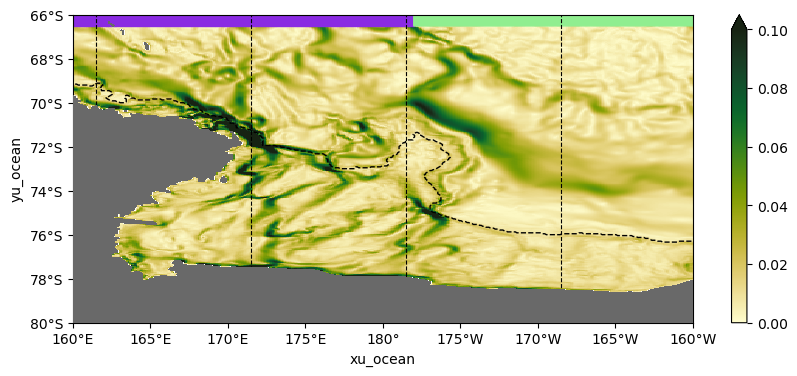

In [196]:
#GLomar region Checking
figure = plt.figure(figsize = (10, 4))
ax325 = plt.subplot(1,1,1)

#Vel.isel(st_ocean=0).plot.pcolormesh(cmap = cmo.speed,vmin=0,vmax=0.4,add_colorbar=True)
Vel_mean.plot.pcolormesh(cmap = cmo.speed,vmin=0,vmax=0.1,add_colorbar=True)
ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             zorder=6)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'black', linewidths=1,linestyles='--')


for k in range(35):
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=1,color='k',zorder=0)
    ax325.plot([bins_west[k],bins_west[k]],[-80,-60],linewidth=0.8,color='k',linestyle='--',zorder=5)


ax325.fill_between([-29,-54],[-66.5,-66.5],[1,1], color = 'blueviolet')
ax325.fill_between([-178,-228],[-66.5,-66.5],[1,1], color = 'blueviolet')
ax325.fill_between([70,45],[-66.5,-66.5],[1,1], color = 'blueviolet')
## F regions
ax325.fill_between([-54,-56],[-66.5,-66.5],[1,1], color = 'lightgreen')
ax325.fill_between([-120,-178],[-66.5,-66.51],[1,1], color = 'lightgreen')
ax325.fill_between([-228,-247],[-66.5,-66.5],[1,1], color = 'lightgreen')
ax325.fill_between([-279,-258],[-66.5,-66.5],[1,1], color = 'lightgreen')
ax325.fill_between([70,80],[-66.5,-66.5],[1,1], color = 'lightgreen')
ax325.fill_between([-29,45],[-66.5,-66.5],[1,1], color = 'lightgreen')
## W regions
ax325.fill_between([-120,-56],[-66.5,-66.5],[1,1], color = 'tomato')
ax325.fill_between([-247,-258],[-66.5,-66.5],[1,1], color = 'tomato')


ax325.yaxis.set_major_formatter(LatitudeFormatter())
ax325.xaxis.set_major_formatter(LongitudeFormatter())
ax325.set_ylim(-80,-66)
ax325.set_xlim(-200,-160)